In [1]:
"""main discoveries after reading Zach's paper:
1. His orbiting hotspot model is a point source, not a Gaussian. We can approximate this by setting the xwidth and ywidth
of the Gaussian close to 0. 
2. His coordinates are in the order of (t, r, phi, theta), while in AART it's (t, r, theta, phi).

Questions: 
2. Does the magnetic field functions take radians or degrees as inputs? Answer: Radians

"""


# import all functions from the Adaptive Analytical Ray Tracing code library
from aart_func import * 
from params import * # The file params.py contains all the relevant parameters for the simulations
from tqdm import tqdm
import b_transformer as bt
#import importlib


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca



In [2]:
print(i_case)
print(spin_case)

70
0.02


In [3]:
# run lensingbands.py
!python lensingbands.py


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Computing the lensing bands
Number of points in the n=0 grid  9000000
Number of points in the n=1 grid  900
Number of points in the n=2 grid  484
File  ./Results/LensingBands_a_0.02_i_70.h5  created.


In [3]:
# read in the results of lensingbands.py
fnbands="./Results/LensingBands_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnbands)

h5f = h5py.File(fnbands,'r')

#Points for the boundary of the BH shadow
alpha_critc=h5f['alpha'][:]
beta_critc=h5f['beta'][:]

#The concave hulls for the lensing bands
hull_0i=h5f['hull_0i'][:]
hull_0e=h5f['hull_0e'][:]
hull_1i=h5f['hull_1i'][:]
hull_1e=h5f['hull_1e'][:]
hull_2i=h5f['hull_2i'][:]
hull_2e=h5f['hull_2e'][:]

#The grid points for each lensing band
supergrid0=h5f['grid0'][:]
N0=int(h5f["N0"][0])
mask0=h5f['mask0'][:]
lim0=int(h5f["lim0"][0])
supergrid1=h5f['grid1'][:]
N1=int(h5f["N1"][0])
mask1=h5f['mask1'][:]
lim1=int(h5f["lim1"][0])
supergrid2=h5f['grid2'][:]
N2=int(h5f["N2"][0])
mask2=h5f['mask2'][:]
lim2=int(h5f["lim2"][0])




h5f.close()


Reading file:  ./Results/LensingBands_a_0.02_i_70.h5


In [5]:
# run raytracing.py
!python raytracing.py


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Ray-tracing
Reading file:  ./Results/LensingBands_a_0.02_i_70.h5
Analytical ray-tracing of the n=0 band points
Analytical ray-tracing of the n=1 band points
Analytical ray-tracing of the n=2 band points
File  ./Results/Rays_a_0.02_i_70.h5  created.

A total of 9001384 photons were ray-traced


In [4]:
# read in the results of raytracing.py
fnrays="./Results/Rays_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

rs0=h5f['rs0'][:]
sign0=h5f['sign0'][:]
t0=h5f['t0'][:]
phi0=h5f['phi0'][:]

rs1=h5f['rs1'][:]
sign1=h5f['sign1'][:]
t1=h5f['t1'][:]
phi1=h5f['phi1'][:]

rs2=h5f['rs2'][:]
sign2=h5f['sign2'][:]
t2=h5f['t2'][:]
phi2=h5f['phi2'][:]



h5f.close()

Reading file:  ./Results/Rays_a_0.02_i_70.h5


In [5]:
r_initial = 8
angle_initial = 1/6 * np.pi
"""What units is omega in? geometrized units of L**-1? pi is not here"""
omega = 1/(r_initial**1.5 + spin_case)


def intensity_transform(grid, mask, redshift_sign, rsource, thetasource, timesource, t):
    """ Here is a brief explanation of the parameters for this function: 
    
        grid: grid that is returned by lensingbands.py (contains the alpha and beta coordinates)
        mask: mask that is returned by lensing bands.py (? what exactly is mask, and why is it always used as an index?) it is a boolean array
        , but why can it be used to index both alpha and beta (which is on the observer plane), and r, theta, t (which is on the source plane)?
        possibly because mask specifies whether a point, in both observer and source plane, is within a particular lensing band. 
        redshift_sign: ??? what is the redshift sign and how is it used? 
        rsource: the r coordinate in the source plane
        thetasource: the theta coordinate in the source plane
        timesource: the time coordinate in the source plane
       
    """
    
    # first, we extract the alpha and beta coordinates from the parameter "grid". Recall that "grid" is calculated by lensingbands.py.
    alpha = grid[:,0][mask]
    beta = grid[:, 1][mask] 
    #sidenote on python syntax: [:, 0] means that we select all the rows of the array, as well as the index 0 column
    # which means we are effectively selecting all elements in the index 0 column.
    # now, if we apply an extra [mask] to that (and mask is an array consisting of booleans), we select elements in the index 0 column
    # that fits the condition of true as specified by mask. 
    
    # next, we extract the source r, theta, and t coordinates from the parameters "rsource", "thetasource", and "timesource"
    r = rsource[mask]
    theta = thetasource[mask]
    time = timesource[mask]
    
     # next, we extract the redshift signs from the parameter "redshift_sign"
    sign = redshift_sign[mask]
    
    # next, we calculate the angular momentum and carter constant, which is needed to calculate the observer intensity
    angular_momentum, carter_constant = rt.conserved_quantities(alpha, beta, i_case, spin_case)
      # side note: i_case is measured from the spin axis of the black hole. (?? is that the only parameter that is needed, say
        # what if we had two observers at the same i_case but different thetas?)
        
    # then, we create an empty array that represents the intensity at the source plane. This array can be customized later. For now we only
    # need to know the size.
    intensitysource = np.zeros(r.shape[0])
    # side note on python syntax: r.shape gives the number of rows in the array r. In the case of r being a one-dimensional array, it simply gives
    # the number of elements. 
    
    
    # Currently, the source plane is desribed by polar coordinates. In this next step, we translate it into Cartesian coordinates. 
    x = r * cos(theta)
    y = r * sin(theta)
    
    # time-dependent motion of the centroid of the gaussian
    
    x0 = r_initial * np.cos (angle_initial + omega * t)
    y0 = r_initial * np.sin (angle_initial + omega * t)
    
    gwdithx=0.05
    gwdithy=0.05
    
    # next, we define a specific intensity profile in the source plane: in this case, a Gaussian centered at (10, 10) with xwidth and ywidth both 5
    brightness = np.exp(-(x-x0)**2/gwdithx**2-(y-y0)**2/gwdithy**2)
    # the reason we do not need to create a meshgrid here: we are already given all the corresponding (x,y) coordinates that lie within a particular lensing band.
    
    
    # now we coome to the most crucial step: calculating the intensity at the observer plane.There are two scenarios: when the radius is smaller 
    # than the innermost stable orbit, and when the radius is larger than the innermost stable orbit. 
    isco = rms(spin_case)
    brightness[r < isco] *= obsint.gGas(r[r < isco], spin_case, sign[r < isco], angular_momentum[r < isco], carter_constant[r < isco])
    brightness[r >= isco] *= obsint.gDisk(r[r >= isco], spin_case, sign[r >= isco], angular_momentum[r >= isco], carter_constant[r >= isco])
    
    # naturally, anything that's behind the black hole shadow cannot be seen, so we have to set those brightness to 0.
    r_p = 1+np.sqrt(1-spin_case**2)
    brightness[r <= r_p] = 0
    
    I = np.zeros(mask.shape)
    I[mask] = brightness
    I[mask==0] = np.nan
    return(I)

In [6]:
# first, we specify the local magnetic field in Cartesian coordinates
print(i_case)
print(spin_case)

b_r = 0
b_phi = 0
b_theta = 1

# then, we feed these values into bt.b_local_to_observer_transform to get the coordinates in the observer frame
b_observer_array = bt.b_local_to_observer_transform(b_r, b_phi, b_theta, r_initial)
print(b_observer_array)


70
0.02
[ 0.     0.     0.    -0.125 70.   ]


In [7]:
# now, we plug in the values we calculated above into polarization_f.py in aart_func, and then run the python file.
# now we run polarization.py, which returns EVPA_x and EVPA_y. From these 2 quantities, EVPA can be found using the formula
# on Alejandro and Hengrui's paper page 6 formula 5
!python polarization.py



Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Polarization
Reading file:  ./Results/LensingBands_a_0.02_i_70.h5
Reading file:  ./Results/Rays_a_0.02_i_70.h5
File  ./Results/Polarization_a_0.02_i_70.h5  created.


In [8]:
# read in the outputs of polarization.py

fnpolarization = "./Results/Polarization_a_%s_i_%s.h5"%(spin_case, i_case)

print("Reading file: ", fnpolarization)

h5f = h5py.File(fnpolarization, 'r')

penrosewalker = h5f['PK'][:]
EVPA_x = h5f['EVPA_x'][:]
EVPA_y = h5f['EVPA_y'][:]
             

h5f.close()

print(penrosewalker.shape)
print(EVPA_x.shape)
print(EVPA_y.shape)



Reading file:  ./Results/Polarization_a_0.02_i_70.h5
(2500, 2500)
(2500, 2500)
(2500, 2500)


In [9]:
# here we specify the total time
totaltime = 150

# First, we initialize the Q and U arrays
Q_array=np.zeros(totaltime)
U_array=np.zeros(totaltime)

EVPA = np.arctan(-EVPA_x/EVPA_y) # we can do this calculation outside of the for loop because EVPA only depends on local B field
# and the geometry as calculated by lensingbands and raytracing

j = complex(0,1) # j stands for the imaginary number "i"


#for dt in range(totaltime):
for dt in tqdm(range(totaltime)):

    # retrive I0 from intensity_transform function
    I0 = intensity_transform(supergrid0, mask0, sign0, rs0, phi0, t0, dt)
    I0 = (I0).reshape(N0,N0).T

    # calculate total intensity
    Itotal = I0
    
    # Calculate the observed linear polarization P_0 = m * I_0 * exp(2*i*EVPA), where m is the fractional degree of polarization.
    # Here, we take m = 1.
    P_0 = Itotal * np.exp(2*j*EVPA)
    
    # now we extract Q, which is the real part of P_0
    P_0_real = P_0.real
    
    # then we extract U, which is the imaginary part of P_0
    P_0_imaginary = P_0.imag
    
    # we calculate the Q flux at this instant in time
    Q_flux = np.nansum(P_0_real)
    
    # we calculate the U flux at this instant in time
    U_flux = np.nansum(P_0_imaginary)
    
    # we add Q_flux and U_flux to their respective arrays
    Q_array[dt]=Q_flux
    U_array[dt]=U_flux
    

print(Q_array)
print(U_array)
    

100%|██████████| 150/150 [02:43<00:00,  1.09s/it]

[ -5.16298482  -5.25844887  -5.36345635  -5.47882838  -5.60540679
  -5.74401573  -5.89539843  -6.06011622  -6.23839144  -6.4298691
  -6.633262    -6.84583576  -7.0626869   -7.27578338  -7.47280642
  -7.63601544  -7.74177205  -7.76215515  -7.67136639  -7.46099114
  -7.16798186  -6.91364195  -6.93618471  -7.57482395  -9.14865807
 -11.71433625 -14.83809195 -17.69060047 -19.55509776 -20.24911306
 -20.03791682 -19.30459128 -18.34714416 -17.34289015 -16.38066898
 -15.49781877 -14.70510185 -14.00072479 -13.37757531 -12.82676883
 -12.33930419 -11.90678026 -11.52165751 -11.17730518 -10.8679539
 -10.58861178 -10.33497128 -10.10332225  -9.89046397  -9.69366105
  -9.5105387   -9.33902449  -9.17741896  -9.0244969   -8.87824883
  -8.7382611   -8.6041506   -8.47440846  -8.3479823   -8.22342233
  -8.10309105  -7.99051623  -7.86875273  -7.76277202  -7.65383739
  -7.54115967  -7.43424406  -7.33550781  -7.23330814  -7.11664842
  -7.03608807  -6.93350462  -6.82931252  -6.73823998  -6.66026921
  -6.5570196

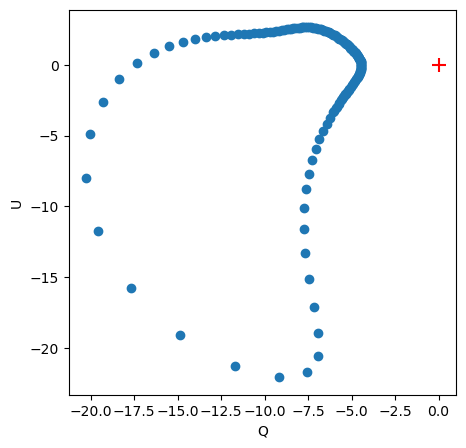

In [10]:
# now we want to plot them on a graph. 

fig, ax = plt.subplots(figsize=[5,5])

Q=np.array(Q_array)
U=np.array(U_array)

plt.scatter(Q, U)
plt.scatter(0, 0, color='red', s=100, marker = "+")
plt.xlabel("Q")
plt.ylabel("U")
#plt.xlim(-5,5)
#plt.ylim(-5, 5)
#plt.text(-4, 16, fr'$\theta$ = {i_case}, $r_s$ = {r_initial}', fontsize=12)
plt.savefig(f"hotspot_polarization/({b_r}_{b_phi}_{b_theta})_theta_{i_case}_rs_{r_initial}_unswapped1", dpi = 100)
plt.show()



TODO:

- Systematically check the convention of the angles
- Trace back Zack's code and compare to yours. Every computation! We need to be sure of the steps of those tetrads and transformation

Do we need this extra line of code?: coordtransform = np.matmul(np.matmul(minkmetric, getlorentzboost(-boost, chi)), emutetrad) essentially multiplying by
another Minkowski Metric. 

angle conventions
did they use equation 46?
